In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tqdm
from tqdm import tqdm
import nltk
import warnings
warnings.filterwarnings("ignore") 
import cv2
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import time

import tensorflow as tf
import keras
from keras.layers import Input,Dense,Conv2D,concatenate,Dropout,LSTM
from keras import Model
from tensorflow.keras import activations
import warnings
warnings.filterwarnings("ignore")
import nltk.translate.bleu_score as bleu

https://github.com/ashishthomaschempolil/Medical-Image-Captioning-on-Chest-X-rays/blob/main/3_Attention_Model_Medical_Report.ipynb

https://github.com/tankmitesh/Medical-Report-predication-with-deep-learning

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
chexnet_weights="/kaggle/input/fyp2-dataset/brucechou1983_CheXNet_Keras_0.3.0_weights.h5"

In [4]:

'''
First we need to load the chexnet nodel (DenseNet121),
The trained weight of this model is from https://github.com/brucechou1983/CheXNet-Keras

'''
#https://github.com/antoniosehk/tCheXNet/blob/master/chexnet.py
from tensorflow.keras.applications import DenseNet121

image_shape= (224,224,3)
image_input= Input(shape=(224,224,3))
base=DenseNet121(include_top=False,input_tensor=image_input,input_shape=image_shape,pooling="avg")
pred=Dense(14,"sigmoid")(base.output)

chexnet_model=Model(inputs=base.input,outputs=pred)
chexnet_model.load_weights(chexnet_weights)

chexnet_model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [5]:
final_chexnet_model=Model(inputs=chexnet_model.inputs,outputs=chexnet_model.layers[-2].output,name="Chexnet_model")   

In [6]:
image_folder = "/kaggle/input/fyp2-dataset/NLMCXR_png"
df_path = "/kaggle/input/fyp2-dataset/NLMCXR_reports/NLMCXR_reports/ecgen-radiology"

In [7]:
train=pd.read_csv("/kaggle/input/dataset8020/impression_train_final8020.csv")
test=pd.read_csv("/kaggle/input/dataset8020/impression_test_final8020.csv")

In [8]:
print(train.shape) 
print(test.shape)

(4404, 6)
(764, 5)


In [9]:
train.head()

Unnamed: 0                             impression  \
0           0  no acute cardiopulmonary abnormality    
1           1                      no acute disease    
2           2  no acute cardiopulmonary abnormality    
3           3  no acute cardiopulmonary abnormality    
4           4  no acute cardiopulmonary abnormality    

                               image_1                              image_2  \
0  NLMCXR_png/CXR2401_IM-0950-1001.png  NLMCXR_png/CXR2401_IM-0950-2001.png   
1   NLMCXR_png/CXR251_IM-1032-1001.png   NLMCXR_png/CXR251_IM-1032-3001.png   
2   NLMCXR_png/CXR211_IM-0740-1001.png   NLMCXR_png/CXR211_IM-0740-1002.png   
3  NLMCXR_png/CXR2391_IM-0944-1001.png  NLMCXR_png/CXR2391_IM-0944-2001.png   
4  NLMCXR_png/CXR1933_IM-0604-1001.png  NLMCXR_png/CXR1933_IM-0604-1002.png   

   impression_counts                                   impression_final  
0                411  <SOS> no acute cardiopulmonary abnormality  <EOS>  
1                110                      <SOS> no acute disease  <EOS>  
2                411  <SOS> no acute cardiopulmonary abnormality  <EOS>  
3                411  <SOS> no acute cardiopulmonary abnormality  <EOS>  
4                411  <SOS> no acute cardiopulmonary abnormality  <EOS>

### Features Extraction of image features from the Chexnet Model

In [10]:
image_1= Input(shape=(224,224,3),name="image_1_features")
image_2= Input(shape=(224,224,3),name="image_2_features")
image_1_out=final_chexnet_model(image_1)
image_2_out=final_chexnet_model(image_2)
conc=concatenate((image_1_out,image_2_out),axis=-1,name="final_image_features")
feature_extraction_model=Model(inputs=[image_1,image_2],outputs=conc)
feature_extraction_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_1_features (InputLayer)  [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 image_2_features (InputLayer)  [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Chexnet_model (Functional)     (None, 1024)         7037504     ['image_1_features[0][0]',       
                                                                  'image_2_features[0][0]'] 

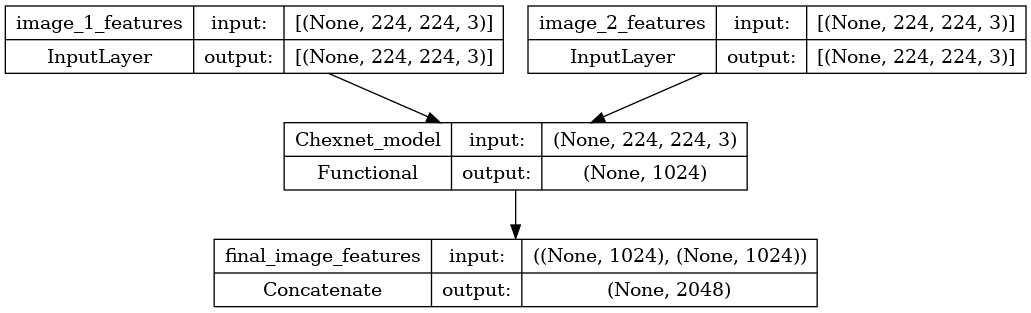

In [11]:
tf.keras.utils.plot_model(feature_extraction_model,show_shapes=True,show_layer_names=True) 

In [12]:
'''
Obtaining the image feature for every patient using the feature extraction model which we had build earlier.
The output from this function is 2048 dimensiona vector for the x-ray set of every patient
'''

def image_feature_extraction(image1,image2):
  
 
  image_1 = Image.open(image1)
  
  image_1= np.asarray(image_1.convert("RGB"))
  
  
  image_2=Image.open(image2)
  image_2 = np.asarray(image_2.convert("RGB"))

    #normalize the values of the image
  image_1=image_1/255
  image_2=image_2/255

    #resize all image into (224,224)
  image_1 = cv2.resize(image_1,(224,224))
  image_2 = cv2.resize(image_2,(224,224))
    
  image_1= np.expand_dims(image_1, axis=0)
  image_2= np.expand_dims(image_2, axis=0)
    
    #now we have read two image per patient. this is goven to the chexnet model for feature extraction
    
  image_feature=feature_extraction_model([image_1,image_2])
  
  return image_feature

In [13]:
root_path = "/kaggle/input/fyp2-dataset/NLMCXR_png/"

In [14]:
train_features=np.load("/kaggle/input/chexrayimpressionimgfeature80201dim/train_image_features8020 (1).npz")
train_features=train_features['arr_0']
test_features=np.load("/kaggle/input/chexrayimpressionimgfeature80201dim/test_image_features8020 (1).npz")
test_features=test_features['arr_0']

In [15]:
print(train_features.shape)
print(test_features.shape) 

(4404, 1, 2048)
(764, 1, 2048)


In [16]:
k=100
print(test_features[k])
one=test.iloc[k]["image_1"] 
two=test.iloc[k]["image_2"]

print(image_feature_extraction(root_path+one,root_path+two))  

[[0.         0.00191964 0.0013159  ... 0.81735057 0.8349675  0.6745591 ]]
tf.Tensor([[0.         0.00191964 0.0013159  ... 0.81735057 0.8349675  0.6745591 ]], shape=(1, 2048), dtype=float32)


In [17]:
train.head()

Unnamed: 0                             impression  \
0           0  no acute cardiopulmonary abnormality    
1           1                      no acute disease    
2           2  no acute cardiopulmonary abnormality    
3           3  no acute cardiopulmonary abnormality    
4           4  no acute cardiopulmonary abnormality    

                               image_1                              image_2  \
0  NLMCXR_png/CXR2401_IM-0950-1001.png  NLMCXR_png/CXR2401_IM-0950-2001.png   
1   NLMCXR_png/CXR251_IM-1032-1001.png   NLMCXR_png/CXR251_IM-1032-3001.png   
2   NLMCXR_png/CXR211_IM-0740-1001.png   NLMCXR_png/CXR211_IM-0740-1002.png   
3  NLMCXR_png/CXR2391_IM-0944-1001.png  NLMCXR_png/CXR2391_IM-0944-2001.png   
4  NLMCXR_png/CXR1933_IM-0604-1001.png  NLMCXR_png/CXR1933_IM-0604-1002.png   

   impression_counts                                   impression_final  
0                411  <SOS> no acute cardiopulmonary abnormality  <EOS>  
1                110                      <SOS> no acute disease  <EOS>  
2                411  <SOS> no acute cardiopulmonary abnormality  <EOS>  
3                411  <SOS> no acute cardiopulmonary abnormality  <EOS>  
4                411  <SOS> no acute cardiopulmonary abnormality  <EOS>

In [18]:
'''
Modify the reports as <sos> report text <eos>. This format is useful for the decoder while predicting the next word
'''

train_report=["<sos> "+text+" <eos>" for text in train["impression"].values]

test_report=["<sos> " +text+" <eos>" for text in test["impression"].values]


In [19]:
print(train_report[0])
print(train_report[1])

<sos> no acute cardiopulmonary abnormality  <eos>
<sos> no acute disease  <eos>


In [20]:
#Obtaining the text embeddings of the report
# we use the tensorflow tokenizer to convert the text into tokens
#we also pad the sequences to a length 300 which is around the 90th percentile of the lengths of the report

token=tf.keras.preprocessing.text.Tokenizer(filters='' )

token.fit_on_texts(train_report)
vocab_size=len(token.word_index)+1 
print(vocab_size)

1306


In [21]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embeddings_index=dict()
f = open("/kaggle/input/gloveembedding/glove.6B.300d.txt")
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print("Done")
# create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(token.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector 

Done


100%|██████████| 1305/1305 [00:00<00:00, 203531.28it/s]


In [22]:
max_len=22

In [34]:


# Constructing the encoder-decoder model

# Encoder model
input_1 = Input(shape=(2048,), name="Images")
encoder_out = Dense(512, activation="relu", name="enc_dense")(input_1)

# Decoder model
input_text = Input(shape=(max_len,), name="text")

embedding_out = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len, mask_zero=True, trainable=False, weights=[embedding_matrix])(input_text)

lstm_out = LSTM(units=512, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
               recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
               bias_initializer=tf.keras.initializers.zeros(), return_sequences=False, name="LSTM")(embedding_out)

x = Dropout(0.5)(lstm_out)
add = tf.keras.layers.Add()([encoder_out, x])

x = Dense(512, kernel_initializer=tf.keras.initializers.he_normal(seed=1), activation="relu")(add)
x = Dropout(0.25)(x)
x = Dense(vocab_size, activation="softmax")(x)

# Encoder-decoder model
encoder_decoder = Model(inputs=[input_1, input_text], outputs=x)
encoder_decoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 22)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 22, 300)      391800      ['text[0][0]']                   
                                                                                                  
 Images (InputLayer)            [(None, 2048)]       0           []                               
                                                                                                  
 LSTM (LSTM)                    (None, 512)          1665024     ['embedding_1[0][0]']            
                                                                                            

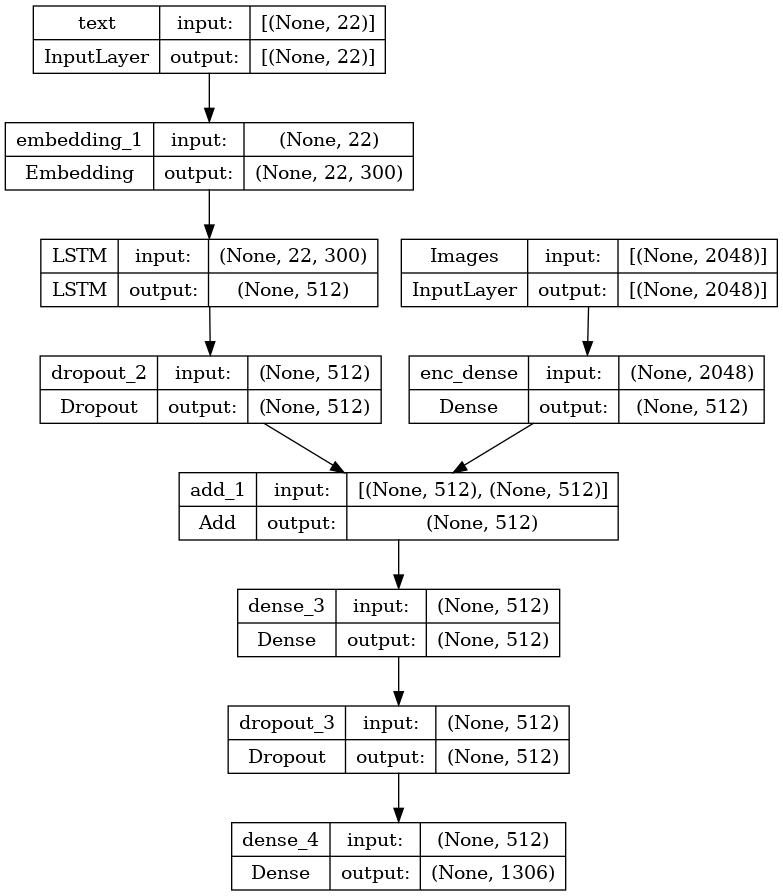

In [35]:
tf.keras.utils.plot_model(encoder_decoder,show_shapes=True,show_layer_names=True,to_file="model1.png") 

In [25]:
batch_size=20

In [36]:
#now we prepare the data set with the image fetaures and the reports
train_dataset = tf.data.Dataset.from_tensor_slices((train_features,train_report))
train_dataset = train_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_features,test_report))
test_dataset = test_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE) 


In [27]:
#printing the last batch of train dataset
for element in train_dataset:
  pass
print(element) 

(<tf.Tensor: shape=(4, 1, 2048), dtype=float32, numpy=
array([[[2.6695844e-04, 2.1079227e-03, 4.2275633e-03, ...,
         8.0948484e-01, 8.3270007e-01, 6.6346663e-01]],

       [[4.2269489e-04, 1.9715491e-03, 3.0376352e-03, ...,
         7.9831928e-01, 8.3447671e-01, 6.5688848e-01]],

       [[6.2601588e-04, 2.0686521e-03, 3.2739250e-03, ...,
         8.1103051e-01, 8.5459524e-01, 6.6843361e-01]],

       [[2.2814235e-04, 2.1165113e-03, 1.4442547e-03, ...,
         8.1614941e-01, 8.5064924e-01, 6.6671598e-01]]], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=string, numpy=
array([b'<sos> emphysema and scarring without acute disease  <eos>',
       b'<sos> no acute cardiopulmonary abnormality stable bullous emphysematous changes  <eos>',
       b'<sos> hyperexpanded but clear lungs  <eos>',
       b'<sos> no acute cardiopulmonary abnormality lucent lesion with thin sclerotic margin the right humeral head considering the associated degenerative changes large geode most further imaging d

In [37]:
'''
Here we load the data to be tained. For each batch from train dataset, we prepare the data like:
for report1, image1 in each batch:
  report is tokenized
  input1= token of <sos>----> 
  output1=<token of next_word in report1>
  image=image1

  input2=token of <sos><token of second word in report1>
  output1=<token of third word>
  image=image1
  .
  .
  .

'''
def load_data(images,reports_unpadded):
    #images=tf.reshape(image,shape=(image.shape[0],image.shape[-1]))
    imgs = []
    input_reports = []
    output_reports = []
    #print(len(images))
    for i in range(len(images)):
      sequence=[] 
      for ele in reports_unpadded[i].split(" "):
        if ele in token.word_index.keys():
          sequence.append(token.word_index[ele])
      #  print(sequence)
      for j in range(1,len(sequence)):

            in_seq = sequence[:j]
            
            
            out_seq = sequence[j]
            
            out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)

            imgs.append(images[i])
            
            input_reports.append(in_seq)
            
            output_reports.append(out_seq)
        
    return np.array(imgs), np.array(input_reports), np.array(output_reports)



In [38]:
#https://www.tensorflow.org/tutorials/text/nmt_with_attention

loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='auto')

def maskedLoss(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_



In [39]:
encoder_decoder.compile(optimizer="Adam", loss = maskedLoss,metrics=['accuracy'])

In [31]:
import datetime
import time

In [40]:
train_loss_list = []
test_loss_list=[]

train_accu_list = []
test_accu_list=[]

In [41]:
for epoch in range(20):
    print('EPOCH : ',epoch+1)
    start = time.time()
    batch_loss_train = 0
    batch_loss_test = 0

    batch_accu_train = 0
    batch_accu_test = 0
    
    for img, report in train_dataset:
        
        r1 = [word.decode('utf-8') for word in np.array(report)] # convert the tensor to array and then decode it 

        #for each set of elements in dataset prepare the data using load_data function
        img_input, rep_input, output_word = load_data(img.numpy(), r1)
        #padd the input so as to feed into the model
        rep_input = tf.keras.preprocessing.sequence.pad_sequences(rep_input, maxlen=22, padding='post')
        img_input=tf.reshape(img_input,shape=(img_input.shape[0],img_input.shape[-1]))
        
        m_return = encoder_decoder.train_on_batch([img_input, rep_input], output_word)
        batch_loss_train += m_return[0]
        batch_accu_train += m_return[1]
    train_loss = batch_loss_train/(len(train_report)//20)
    train_accu = batch_accu_train/(len(train_report)//20)
    
    
    for img, report in test_dataset:
        
        r1 = [word.decode('utf-8') for word in np.array(report)]
        img_input, rep_input, output_word = load_data(img.numpy(), r1)
        rep_input = tf.keras.preprocessing.sequence.pad_sequences(rep_input, maxlen=22, padding='post')
        img_input=tf.reshape(img_input,shape=(img_input.shape[0],img_input.shape[-1]))
        m_return = encoder_decoder.test_on_batch([img_input, rep_input], output_word)
        batch_loss_test += m_return[0]
        batch_accu_test += m_return[1]

    
    test_loss = batch_loss_test/(len(test_report)//20)
    test_accu = batch_accu_test/(len(test_report)//20)
    

    train_loss_list.append(train_loss)
    train_accu_list.append(train_accu)

    test_loss_list.append(test_loss)
    test_accu_list.append(test_accu)

    print('Training Loss: {},  Val Loss: {}'.format(train_loss, test_loss))
    print('Training accu: {},  Val accu: {}'.format(train_accu, test_accu))
    print('Time Taken for this Epoch : {} sec'.format(time.time()-start))   
encoder_decoder.save_weights('/kaggle/working/encoder_decoder_epoch_8020_22GRU.h5')


EPOCH :  1
Training Loss: 0.003915661131031811,  Val Loss: 0.0027557145252725796
Training accu: 0.1376269716430794,  Val accu: 0.38648469432404164
Time Taken for this Epoch : 22.851149082183838 sec
EPOCH :  2
Training Loss: 0.0030021058638918805,  Val Loss: 0.0023428870420167712
Training accu: 0.26467219516634943,  Val accu: 0.4511687904596329
Time Taken for this Epoch : 9.893149137496948 sec
EPOCH :  3
Training Loss: 0.0024963197102558544,  Val Loss: 0.00222967426280344
Training accu: 0.33287530290809547,  Val accu: 0.482257112076408
Time Taken for this Epoch : 10.884207248687744 sec
EPOCH :  4
Training Loss: 0.0020870033619840712,  Val Loss: 0.0022357337078765817
Training accu: 0.40010686313564126,  Val accu: 0.48056006196298096
Time Taken for this Epoch : 10.51427412033081 sec
EPOCH :  5
Training Loss: 0.0017531966531268237,  Val Loss: 0.0022660994130235756
Training accu: 0.4683257025751201,  Val accu: 0.48787741519902883
Time Taken for this Epoch : 11.09652328491211 sec
EPOCH :  6


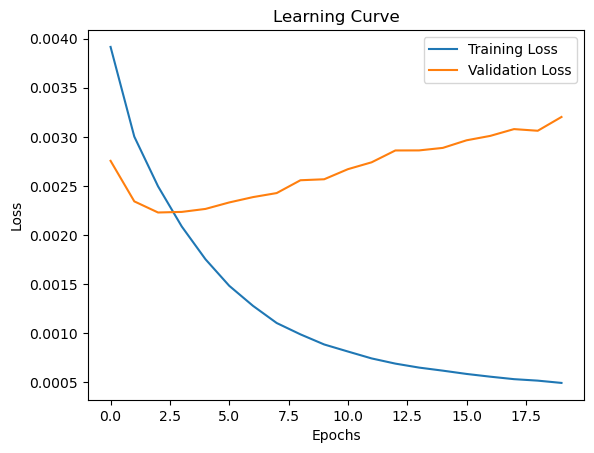

In [42]:
import matplotlib.pyplot as plt
# Plot the learning curve
epochs = len(train_loss_list)
plt.plot(range(epochs), train_loss_list, label='Training Loss')
plt.plot(range(epochs), test_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()

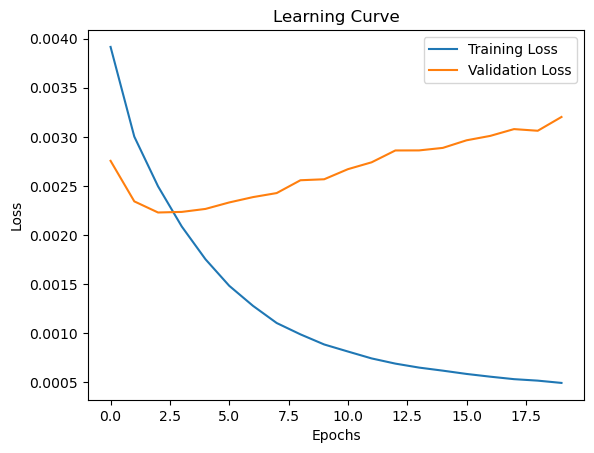

In [43]:
import matplotlib.pyplot as plt
# Plot the learning curve
epochs = len(train_loss_list)
plt.plot(range(epochs), train_loss_list, label='Training Loss')
plt.plot(range(epochs), test_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()

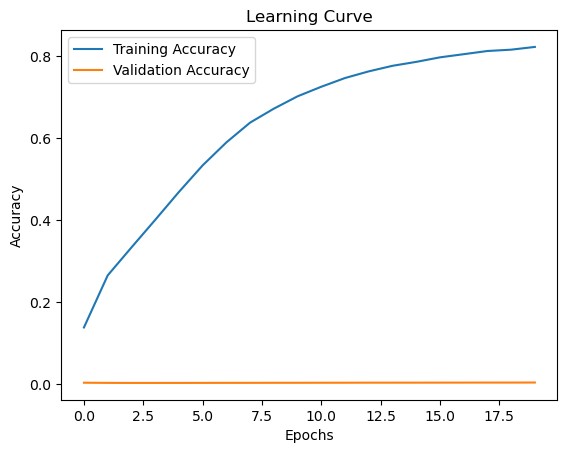

In [44]:
import matplotlib.pyplot as plt
# Plot the learning curve
epochs = len(train_accu_list)
plt.plot(range(epochs), train_accu_list, label='Training Accuracy')
plt.plot(range(epochs), test_loss_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()

In [45]:
import time

In [46]:
def evaluate(image1,image2):
    #Given the images from test data, we extract the bottleneck features from chexnet model
    image_features = image_feature_extraction(image1,image2)
    output_report=""
    
    #first word for the report is given as <sos>
    inp= "<sos>"

    image_features=tf.reshape(image_features,shape=(-1,image_features.shape[-1]))
    
    
    
    for i in range(max_len):
        #we find the list of tokens for the input word (already available words)
        list_of_tokens = [token.word_index[w] for w in inp.split()]

        #padd the available tokens to max_len
        input_padded = tf.keras.preprocessing.sequence.pad_sequences([list_of_tokens],max_len, padding='post')
        
        #we pass the image_features and the padded input to the enocoder decoder model and predict the next token
        predictions = encoder_decoder.predict([image_features,input_padded])
        
        #find the corresponding word and attach to the result
        arg = np.argmax(predictions[0]) 
        
        if token.index_word[arg]=="<eos>":
          
          output_report+=token.index_word[arg]+" "
          break
        else:
            
            output_report+=token.index_word[arg]+" "
            inp+= ' ' + token.index_word[arg]
        
    
    return output_report



In [47]:
!pip install pycocoevalcap
!pip install rouge
!pip install -U nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from pycocoevalcap.meteor.meteor import Meteor as MeteorCoco
from pycocoevalcap.rouge.rouge import Rouge as RougeCoco
from rouge import Rouge
from nltk.translate.meteor_score import meteor_score
import nltk
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 11.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl size=93512 sha256=bcc433367ef51f3e4d2db187e828bb5745d2676b5bc0712665925691b91d7630
  Stored in directory: /root/.cache/pip/wheels/58/e6/f9/f87c8f8be098b51b616871315318329cae12cdb618f4caac93
Successfully built pycocotools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have 

In [48]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [49]:
!pip install rouge-score
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
from rouge_score import scoring

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=56e6ce80e09a4e4507adad6c9c9a5cac56b295bb1e568fd7ef5cccebf3f79346
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [50]:
def get_rouge(reference, prediction, variant="rouge-l", measure="f"):
    rouge = Rouge()
    rouge_scores = rouge.get_scores(reference, prediction)
    return rouge_scores[0][variant][measure]

In [51]:
def get_rouge_l(reference, prediction):
    reference_tokens = word_tokenize(reference)
    prediction_tokens = word_tokenize(prediction)
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = scorer.score(' '.join(reference_tokens), ' '.join(prediction_tokens))
    rouge_l_fscore = scores['rougeL'].fmeasure
    return rouge_l_fscore

In [52]:
def get_meteor(reference, prediction):
    hypothesis = [reference.split()]
    reference = prediction.split()
    return meteor_score(hypothesis, reference)

In [53]:
def get_scores(reference,prediction):
    scores = dict()
    for k, v in get_bleu(reference, prediction).items():
        scores[k] = v
    scores["rouge-l"]  = get_rouge(reference, prediction)
    scores["meteor"] = get_meteor(reference, prediction);
    # vale, arr = get_cider(query, groundtruth)
    return scores

In [54]:
def get_bleu(reference,prediction):
  """
  Given a reference and prediction string, outputs the 1-gram,2-gram,3-gram and 4-gram bleu scores
  """
  reference = [reference.split()] #should be in an array (cos of multiple references can be there here only 1)
  prediction = prediction.split()
  bleu1 = bleu.sentence_bleu(reference,prediction,weights = (1,0,0,0))
  bleu2 = bleu.sentence_bleu(reference,prediction,weights = (0.5,0.5,0,0))
  bleu3 = bleu.sentence_bleu(reference,prediction,weights = (0.33,0.33,0.33,0))
  bleu4 = bleu.sentence_bleu(reference,prediction,weights = (0.25,0.25,0.25,0.25))

  return bleu1,bleu2,bleu3,bleu4

In [55]:
import random 
index=range(0,test.shape[0])
b1=0
b2=0
b3=0
b4=0
rouge_all = 0
meteor_all = 0
rouge_l_all=0

blue_top_five = []
blue_min_five = []

rouge_top_five = []
rouge_min_five = []

rouge_l_top_five = []
rouge_l_min_five = []

meteor_top_five = []
meteor_min_five = []

results=[]
start1=time.time()
for i in index:
  print(i)
  img1=root_path+test.iloc[i]["image_1"]
  img2=root_path+test.iloc[i]["image_2"]
  
  result=evaluate(img1,img2) 
  actual=test_report[i]
  img_blue = get_bleu(actual,result)
  rouge = get_rouge(actual,result)
  meteor = get_meteor(actual,result)
  rouge_l = get_rouge_l(actual,result)

  b1+=img_blue[0]
  b2+=img_blue[1]
  b3+=img_blue[2]
  b4+=img_blue[3]

  rouge_all += rouge
  rouge_l_all += rouge_l
  meteor_all += meteor
  
  results.append({
    'Index':i,
    'Image1': img1,
    'Image2': img2,
    'Result': result,
    'Actual': actual,
    'BLEU1': b1,
    'BLEU2': b2,
    'BLEU3': b3,
    'BLEU4': b4,
    'ROUGE': rouge,
    'METEOR': meteor,
    'ROUGE-L': rouge_l
    })
  if len(blue_top_five) < 5:
      blue_top_five.append({"img_blue": img_blue, "rouge": rouge , "rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      blue_min_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      
      rouge_top_five.append({"img_blue": img_blue, "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      rouge_min_five.append({"img_blue": img_blue,  "rouge": rouge , "rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      
      rouge_l_top_five.append({"img_blue": img_blue, "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      rouge_l_min_five.append({"img_blue": img_blue,  "rouge": rouge , "rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      

      meteor_top_five.append({"img_blue": img_blue, "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      meteor_min_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      
  else:
    if img_blue[3] > min(entry["img_blue"][3] for entry in blue_top_five):
        min_index = min(range(len(blue_top_five)), key=lambda i: blue_top_five[i]["img_blue"][3])
        blue_top_five.pop(min_index)
        blue_top_five.append({"img_blue": img_blue,  "rouge": rouge , "rouge_l": rouge_l ,"meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
    if img_blue[3] < max(entry["img_blue"][3] for entry in blue_min_five):
        max_index = max(range(len(blue_top_five)), key=lambda i: blue_min_five[i]["img_blue"][3])
        blue_min_five.pop(max_index)
        blue_min_five.append({"img_blue": img_blue,  "rouge": rouge , "rouge_l": rouge_l ,"meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})

    if rouge > min(entry["rouge"] for entry in rouge_top_five):
        min_index = min(range(len(rouge_top_five)), key=lambda i: rouge_top_five[i]["rouge"])
        rouge_top_five.pop(min_index)
        rouge_top_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
    if rouge < max(entry["rouge"] for entry in rouge_min_five):
        max_index = max(range(len(rouge_top_five)), key=lambda i: rouge_min_five[i]["rouge"])
        rouge_min_five.pop(max_index)
        rouge_min_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})

    if rouge_l > min(entry["rouge_l"] for entry in rouge_l_top_five):
        min_index = min(range(len(rouge_l_top_five)), key=lambda i: rouge_l_top_five[i]["rouge_l"])
        rouge_l_top_five.pop(min_index)
        rouge_l_top_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
    if rouge_l < max(entry["rouge_l"] for entry in rouge_l_min_five):
        max_index = max(range(len(rouge_l_top_five)), key=lambda i: rouge_l_min_five[i]["rouge_l"])
        rouge_l_min_five.pop(max_index)
        rouge_l_min_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})




    if meteor > min(entry["meteor"] for entry in meteor_top_five):
        min_index = min(range(len(meteor_top_five)), key=lambda i: meteor_top_five[i]["meteor"])
        meteor_top_five.pop(min_index)
        meteor_top_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
    if meteor < max(entry["meteor"] for entry in meteor_min_five):
        max_index = max(range(len(meteor_top_five)), key=lambda i: meteor_min_five[i]["meteor"])
        meteor_min_five.pop(max_index)
        meteor_min_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})

end1=time.time() 
print("average bleu score on the test data is ",b1/test.shape[0],b2/test.shape[0],b3/test.shape[0],b4/test.shape[0])
print("average rouge score on the test data is ",rouge_all/test.shape[0])
print("average rouge_l score on the test data is ",rouge_l_all/test.shape[0])
print("average meteor score on the test data is ",meteor_all/test.shape[0])

print('the average time taken for the evaluation is ',(end1-start1)/test.shape[0])

df = pd.DataFrame(results)
df.to_csv('/kaggle/working/ED_8020_22GRU_results.csv')

0
1/1 [==============================] - 0s 23ms/step
1
1/1 [==============================] - 0s 24ms/step
2
1/1 [==============================] - 0s 23ms/step
3
1/1 [==============================] - 0s 23ms/step
4
1/1 [==============================] - 0s 23ms/step
5
1/1 [==============================] - 0s 23ms/step
6
1/1 [==============================] - 0s 22ms/step
7
1/1 [==============================] - 0s 24ms/step
8
1/1 [==============================] - 0s 23ms/step
9
1/1 [==============================] - 0s 23ms/step
10
1/1 [==============================] - 0s 44ms/step
11
1/1 [==============================] - 0s 23ms/step
12
1/1 [==============================] - 0s 23ms/step
13
1/1 [==============================] - 0s 22ms/step
14
1/1 [==============================] - 0s 22ms/step
15
1/1 [==============================] - 0s 22ms/step
16
1/1 [==============================] - 0s 20ms/step
17
1/1 [==============================] - 0s 22ms/step
18
1/1 [============

In [56]:
blue_top_five = sorted(blue_top_five, key=lambda x: x['img_blue'][3], reverse=True)
blue_min_five = sorted(blue_min_five, key=lambda x: x['img_blue'][3], reverse=False)

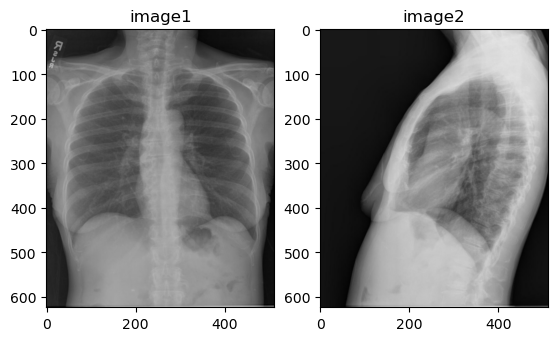

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3319_IM-1588-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3319_IM-1588-2001.png
blue:  (0.846481724890614, 0.846481724890614, 0.846481724890614, 0.846481724890614)
rouge:  0.9230769181065088
rouge_l:  0.923076923076923
meteor:  0.8675523349436391
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality identified  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality identified <eos> 
****************************************************************************************************


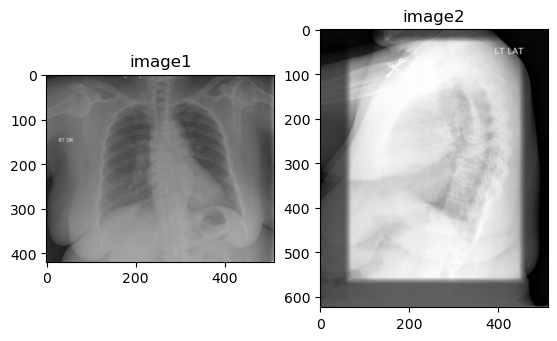

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3642_IM-1806-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3642_IM-1806-2001.png
blue:  (0.8187307530779819, 0.8187307530779819, 0.8187307530779819, 0.8187307530779819)
rouge:  0.9090909041322315
rouge_l:  0.9090909090909091
meteor:  0.8440677966101694
ACTUAL REPORT:  <sos> no acute cardiopulmonary process  <eos>
GENERATED REPORT:  no acute cardiopulmonary process <eos> 
****************************************************************************************************


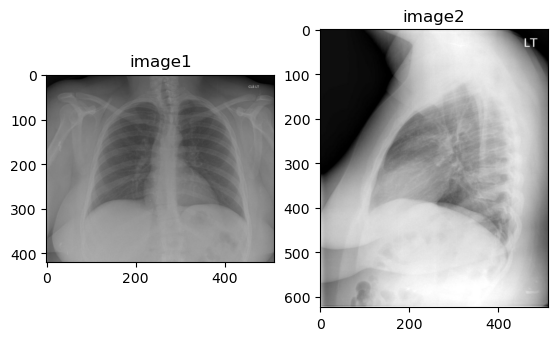

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2270_IM-0859-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2270_IM-0859-2001.png
blue:  (0.8187307530779819, 0.8187307530779819, 0.8187307530779819, 0.8187307530779819)
rouge:  0.9090909041322315
rouge_l:  0.9090909090909091
meteor:  0.8440677966101694
ACTUAL REPORT:  <sos> no acute cardiopulmonary process  <eos>
GENERATED REPORT:  no acute cardiopulmonary process <eos> 
****************************************************************************************************


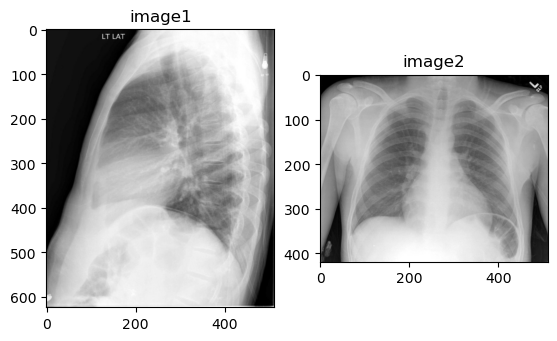

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1744_IM-0489-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1744_IM-0489-2001.png
blue:  (0.8187307530779819, 0.8187307530779819, 0.8187307530779819, 0.8187307530779819)
rouge:  0.9090909041322315
rouge_l:  0.9090909090909091
meteor:  0.8440677966101694
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


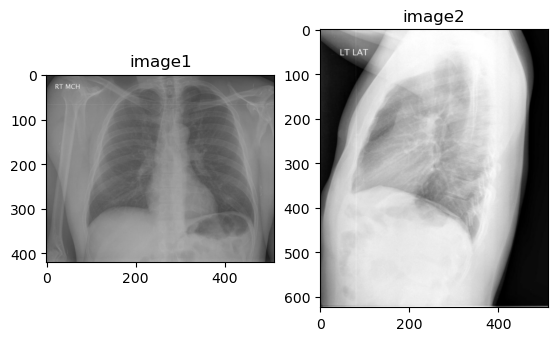

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2020_IM-0668-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2020_IM-0668-2001.png
blue:  (0.8187307530779819, 0.8187307530779819, 0.8187307530779819, 0.8187307530779819)
rouge:  0.9090909041322315
rouge_l:  0.9090909090909091
meteor:  0.8440677966101694
ACTUAL REPORT:  <sos> no acute cardiopulmonary process  <eos>
GENERATED REPORT:  no acute cardiopulmonary process <eos> 
****************************************************************************************************


In [57]:
for i in range(5):
    i1 = cv2.imread(blue_top_five[i]["img1"])
    i2 = cv2.imread(blue_top_five[i]["img2"])
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("image1")
    plt.imshow(i1)
    plt.subplot(132)
    plt.title("image2")
    plt.imshow(i2)
    plt.show()
    print("img1: ", blue_top_five[i]["img1"]) 
    print("img2: ", blue_top_five[i]["img2"]) 

    print("blue: ", blue_top_five[i]["img_blue"]) 
    print("rouge: ", blue_top_five[i]["rouge"]) 
    print("rouge_l: ", blue_top_five[i]["rouge_l"]) 
    print("meteor: ", blue_top_five[i]["meteor"]) 
    print("ACTUAL REPORT: ", blue_top_five[i]["actual"])
    print("GENERATED REPORT: ", blue_top_five[i]["generated"])
    print("*"*100)

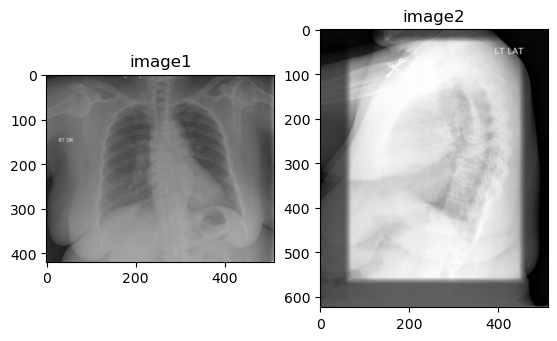

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3642_IM-1806-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3642_IM-1806-2001.png
blue:  (0.8187307530779819, 0.8187307530779819, 0.8187307530779819, 0.8187307530779819)
rouge:  0.9090909041322315
rouge_l:  0.9090909090909091
meteor:  0.8440677966101694
ACTUAL REPORT:  <sos> no acute cardiopulmonary process  <eos>
GENERATED REPORT:  no acute cardiopulmonary process <eos> 
****************************************************************************************************


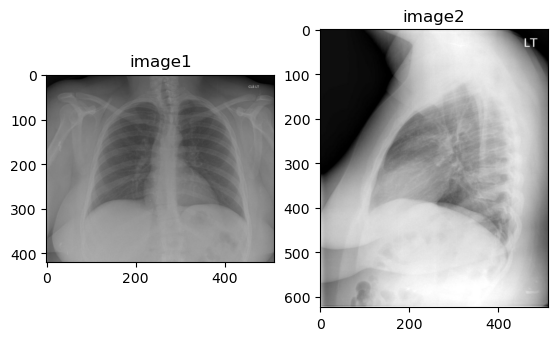

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2270_IM-0859-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2270_IM-0859-2001.png
blue:  (0.8187307530779819, 0.8187307530779819, 0.8187307530779819, 0.8187307530779819)
rouge:  0.9090909041322315
rouge_l:  0.9090909090909091
meteor:  0.8440677966101694
ACTUAL REPORT:  <sos> no acute cardiopulmonary process  <eos>
GENERATED REPORT:  no acute cardiopulmonary process <eos> 
****************************************************************************************************


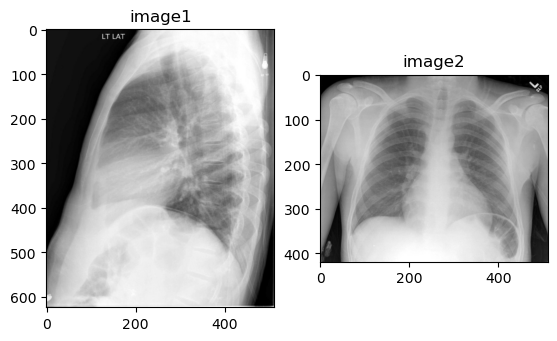

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1744_IM-0489-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1744_IM-0489-2001.png
blue:  (0.8187307530779819, 0.8187307530779819, 0.8187307530779819, 0.8187307530779819)
rouge:  0.9090909041322315
rouge_l:  0.9090909090909091
meteor:  0.8440677966101694
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


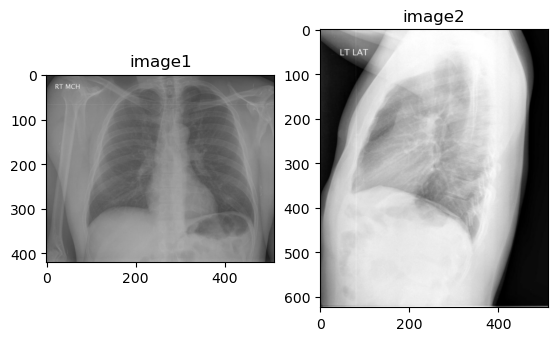

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2020_IM-0668-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2020_IM-0668-2001.png
blue:  (0.8187307530779819, 0.8187307530779819, 0.8187307530779819, 0.8187307530779819)
rouge:  0.9090909041322315
rouge_l:  0.9090909090909091
meteor:  0.8440677966101694
ACTUAL REPORT:  <sos> no acute cardiopulmonary process  <eos>
GENERATED REPORT:  no acute cardiopulmonary process <eos> 
****************************************************************************************************


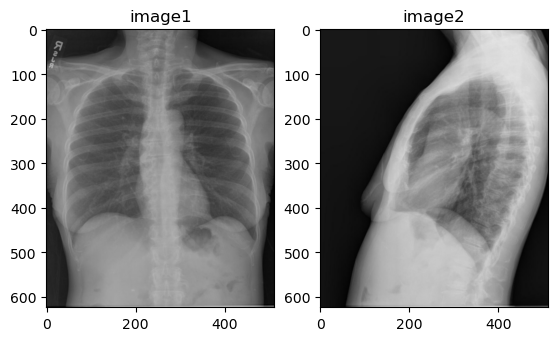

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3319_IM-1588-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3319_IM-1588-2001.png
blue:  (0.846481724890614, 0.846481724890614, 0.846481724890614, 0.846481724890614)
rouge:  0.9230769181065088
rouge_l:  0.923076923076923
meteor:  0.8675523349436391
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality identified  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality identified <eos> 
****************************************************************************************************


In [58]:
for i in range(5):
    i1 = cv2.imread(rouge_top_five[i]["img1"])
    i2 = cv2.imread(rouge_top_five[i]["img2"])
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("image1")
    plt.imshow(i1)
    plt.subplot(132)
    plt.title("image2")
    plt.imshow(i2)
    plt.show()
    print("img1: ", rouge_top_five[i]["img1"]) 
    print("img2: ", rouge_top_five[i]["img2"]) 
    print("blue: ", rouge_top_five[i]["img_blue"]) 
    print("rouge: ", rouge_top_five[i]["rouge"]) 
    print("rouge_l: ", rouge_top_five[i]["rouge_l"]) 
    print("meteor: ", rouge_top_five[i]["meteor"])
    print("ACTUAL REPORT: ", rouge_top_five[i]["actual"])
    print("GENERATED REPORT: ", rouge_top_five[i]["generated"])
    print("*"*100)

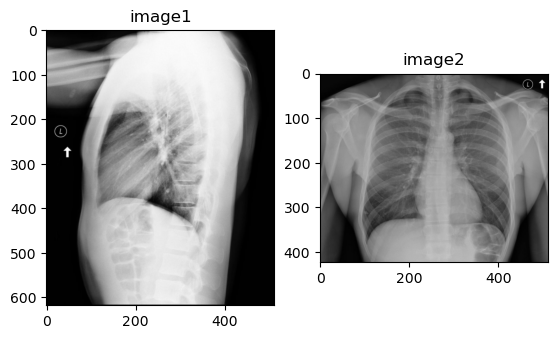

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1767_IM-0501-0001-0001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1767_IM-0501-0001-0002.png
blue:  (0.8187307530779819, 0.8187307530779819, 0.8187307530779819, 0.8187307530779819)
rouge:  0.9090909041322315
rouge_l:  0.9090909090909091
meteor:  0.8440677966101694
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


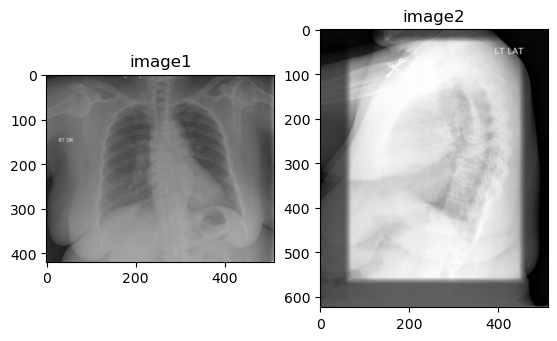

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3642_IM-1806-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3642_IM-1806-2001.png
blue:  (0.8187307530779819, 0.8187307530779819, 0.8187307530779819, 0.8187307530779819)
rouge:  0.9090909041322315
rouge_l:  0.9090909090909091
meteor:  0.8440677966101694
ACTUAL REPORT:  <sos> no acute cardiopulmonary process  <eos>
GENERATED REPORT:  no acute cardiopulmonary process <eos> 
****************************************************************************************************


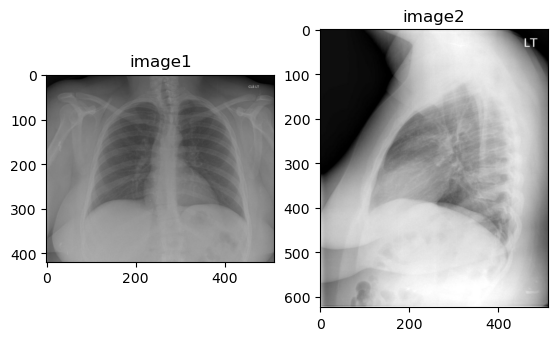

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2270_IM-0859-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2270_IM-0859-2001.png
blue:  (0.8187307530779819, 0.8187307530779819, 0.8187307530779819, 0.8187307530779819)
rouge:  0.9090909041322315
rouge_l:  0.9090909090909091
meteor:  0.8440677966101694
ACTUAL REPORT:  <sos> no acute cardiopulmonary process  <eos>
GENERATED REPORT:  no acute cardiopulmonary process <eos> 
****************************************************************************************************


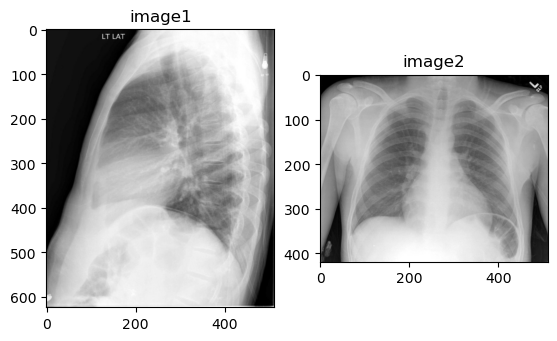

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1744_IM-0489-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1744_IM-0489-2001.png
blue:  (0.8187307530779819, 0.8187307530779819, 0.8187307530779819, 0.8187307530779819)
rouge:  0.9090909041322315
rouge_l:  0.9090909090909091
meteor:  0.8440677966101694
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


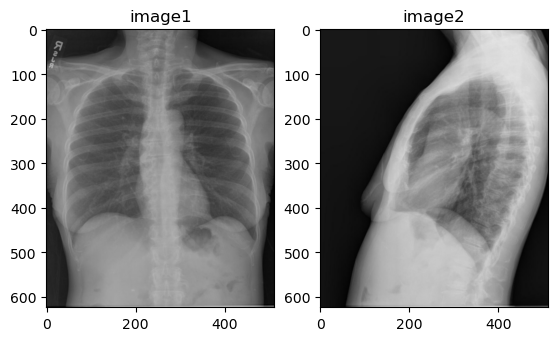

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3319_IM-1588-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3319_IM-1588-2001.png
blue:  (0.846481724890614, 0.846481724890614, 0.846481724890614, 0.846481724890614)
rouge:  0.9230769181065088
rouge_l:  0.923076923076923
meteor:  0.8675523349436391
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality identified  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality identified <eos> 
****************************************************************************************************


In [59]:
for i in range(5):
    i1 = cv2.imread(meteor_top_five[i]["img1"])
    i2 = cv2.imread(meteor_top_five[i]["img2"])
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("image1")
    plt.imshow(i1)
    plt.subplot(132)
    plt.title("image2")
    plt.imshow(i2)
    plt.show()
    print("img1: ", meteor_top_five[i]["img1"]) 
    print("img2: ", meteor_top_five[i]["img2"]) 
    print("blue: ", meteor_top_five[i]["img_blue"]) 
    print("rouge: ", meteor_top_five[i]["rouge"]) 
    print("rouge_l: ", rouge_top_five[i]["rouge_l"]) 
    print("meteor: ", meteor_top_five[i]["meteor"]) 
    print("ACTUAL REPORT: ", meteor_top_five[i]["actual"])
    print("GENERATED REPORT: ", meteor_top_five[i]["generated"])
    print("*"*100)

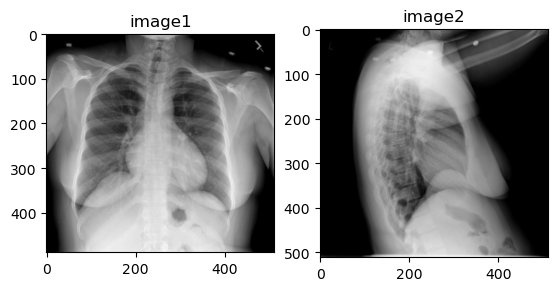

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2940_IM-1341-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2940_IM-1341-2001.png
blue:  (0, 0, 0, 0)
rouge:  0.0
rouge_l:  0.0
meteor:  0.0
ACTUAL REPORT:  <sos> normal chest  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality lucent lesion with thin sclerotic margin the right humeral head considering the associated degenerative changes large geode most 
****************************************************************************************************


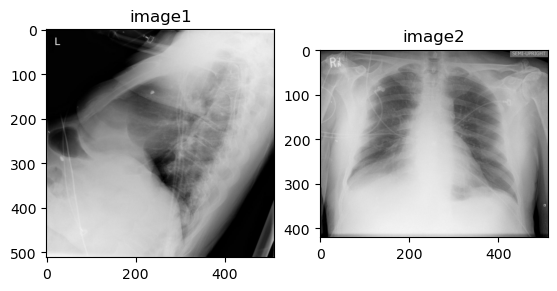

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR455_IM-2086-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR455_IM-2086-4004.png
blue:  (0, 0, 0, 0)
rouge:  0.0
rouge_l:  0.0
meteor:  0.0
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  left picc the mid svc negative for pneumothorax unchanged bibasilar airspace opacities compatible with pulmonary effusions and atelectasis increased interstitial prominence may 
****************************************************************************************************


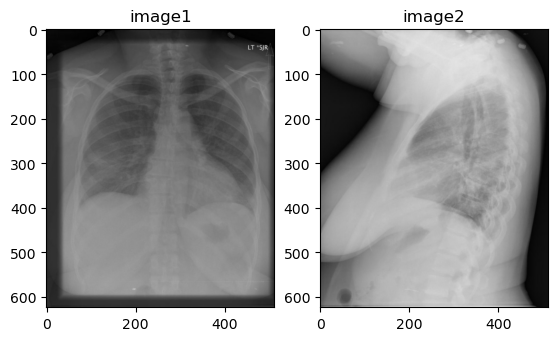

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR672_IM-2246-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR672_IM-2246-2001.png
blue:  (0, 0, 0, 0)
rouge:  0.0
rouge_l:  0.0
meteor:  0.0
ACTUAL REPORT:  <sos> vascular congestion and diffuse interstitial edema stable cardiomegaly low lung volumes  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality nodular opacity within the right hilum there large lymph node partially calcified granuloma followup radiograph assess stability may 
****************************************************************************************************


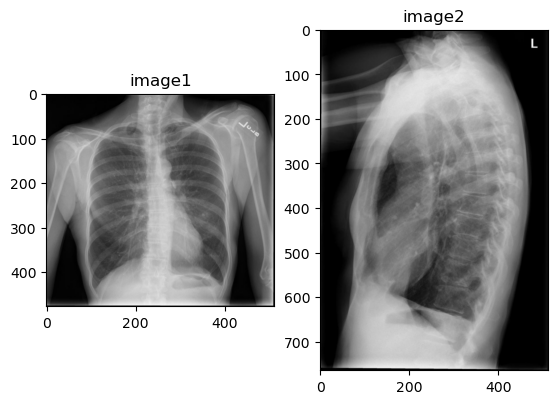

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR615_IM-2200-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR615_IM-2200-1002.png
blue:  (0, 0, 0, 0)
rouge:  0.0
rouge_l:  0.0
meteor:  0.0
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality no suspicious masses nodules  <eos>
GENERATED REPORT:  right lower lobe cavity consistent with prior tuberculous infection there increased right upper lobe cavity compared the prior study this could represent 
****************************************************************************************************


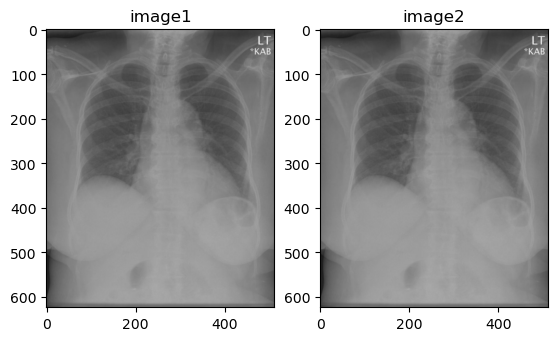

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1082_IM-0058-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1082_IM-0058-1001.png
blue:  (0, 0, 0, 0)
rouge:  0.0
rouge_l:  0.0
meteor:  0.0
ACTUAL REPORT:  <sos> stable cardiomegaly with clear lungs  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality nodular opacity within the right hilum there large lymph node partially calcified granuloma followup radiograph assess stability may 
****************************************************************************************************


In [60]:
for i in range(5):
    i1 = cv2.imread(blue_min_five[i]["img1"])
    i2 = cv2.imread(blue_min_five[i]["img2"])
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("image1")
    plt.imshow(i1)
    plt.subplot(132)
    plt.title("image2")
    plt.imshow(i2)
    plt.show()
    print("img1: ", blue_min_five[i]["img1"]) 
    print("img2: ", blue_min_five[i]["img2"]) 
    print("blue: ", blue_min_five[i]["img_blue"]) 
    
    print("rouge: ", blue_min_five[i]["rouge"]) 
    print("rouge_l: ", blue_min_five[i]["rouge_l"]) 
    print("meteor: ", blue_min_five[i]["meteor"]) 

    print("ACTUAL REPORT: ", blue_min_five[i]["actual"])
    print("GENERATED REPORT: ", blue_min_five[i]["generated"])


    print("*"*100)

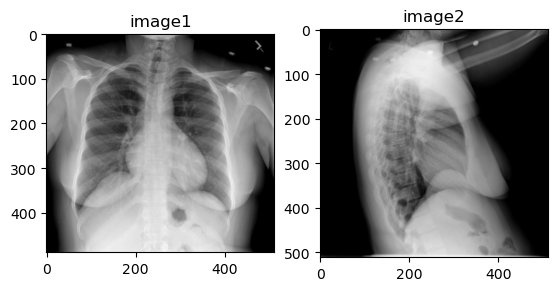

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2940_IM-1341-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2940_IM-1341-2001.png
blue:  (0, 0, 0, 0)
rouge:  0.0
rouge_l:  0.0
meteor:  0.0
ACTUAL REPORT:  <sos> normal chest  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality lucent lesion with thin sclerotic margin the right humeral head considering the associated degenerative changes large geode most 
****************************************************************************************************


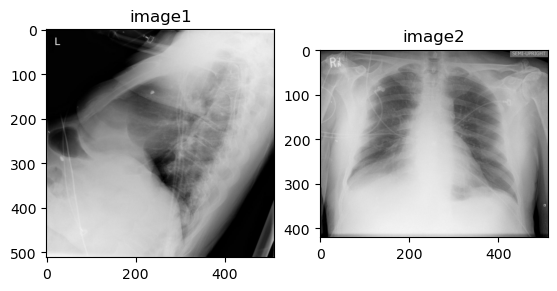

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR455_IM-2086-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR455_IM-2086-4004.png
blue:  (0, 0, 0, 0)
rouge:  0.0
rouge_l:  0.0
meteor:  0.0
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  left picc the mid svc negative for pneumothorax unchanged bibasilar airspace opacities compatible with pulmonary effusions and atelectasis increased interstitial prominence may 
****************************************************************************************************


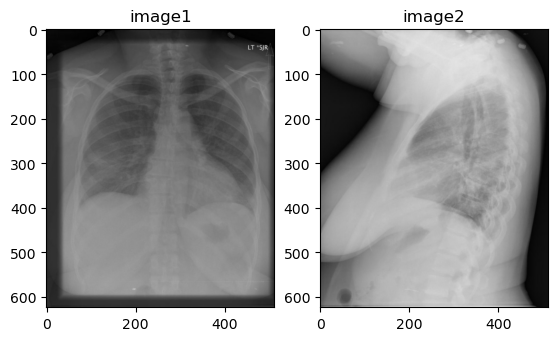

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR672_IM-2246-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR672_IM-2246-2001.png
blue:  (0, 0, 0, 0)
rouge:  0.0
rouge_l:  0.0
meteor:  0.0
ACTUAL REPORT:  <sos> vascular congestion and diffuse interstitial edema stable cardiomegaly low lung volumes  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality nodular opacity within the right hilum there large lymph node partially calcified granuloma followup radiograph assess stability may 
****************************************************************************************************


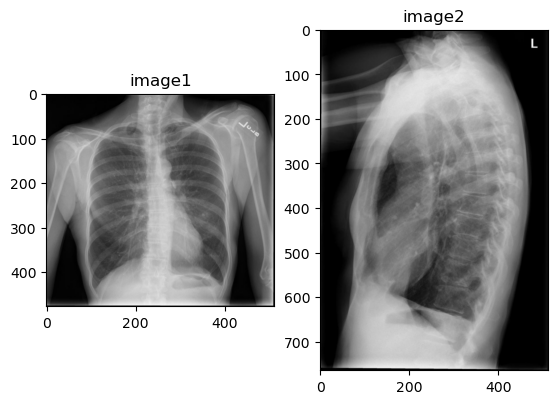

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR615_IM-2200-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR615_IM-2200-1002.png
blue:  (0, 0, 0, 0)
rouge:  0.0
rouge_l:  0.0
meteor:  0.0
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality no suspicious masses nodules  <eos>
GENERATED REPORT:  right lower lobe cavity consistent with prior tuberculous infection there increased right upper lobe cavity compared the prior study this could represent 
****************************************************************************************************


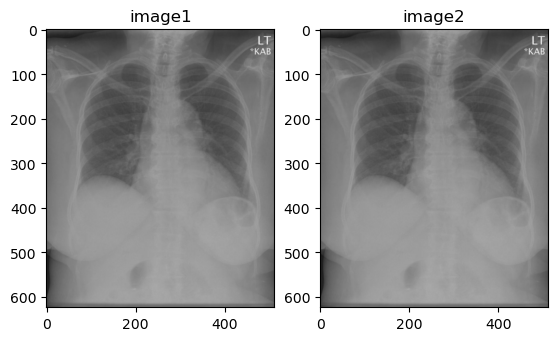

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1082_IM-0058-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1082_IM-0058-1001.png
blue:  (0, 0, 0, 0)
rouge:  0.0
rouge_l:  0.0
meteor:  0.0
ACTUAL REPORT:  <sos> stable cardiomegaly with clear lungs  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality nodular opacity within the right hilum there large lymph node partially calcified granuloma followup radiograph assess stability may 
****************************************************************************************************


In [61]:
for i in range(5):
    i1 = cv2.imread(rouge_min_five[i]["img1"])
    i2 = cv2.imread(rouge_min_five[i]["img2"])
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("image1")
    plt.imshow(i1)
    plt.subplot(132)
    plt.title("image2")
    plt.imshow(i2)
    plt.show()
    print("img1: ", rouge_min_five[i]["img1"]) 
    print("img2: ", rouge_min_five[i]["img2"]) 
    print("blue: ", rouge_min_five[i]["img_blue"]) 
    
    print("rouge: ", rouge_min_five[i]["rouge"]) 
    print("rouge_l: ", rouge_min_five[i]["rouge_l"]) 
    print("meteor: ", rouge_min_five[i]["meteor"]) 

    print("ACTUAL REPORT: ", rouge_min_five[i]["actual"])
    print("GENERATED REPORT: ", rouge_min_five[i]["generated"])


    print("*"*100)

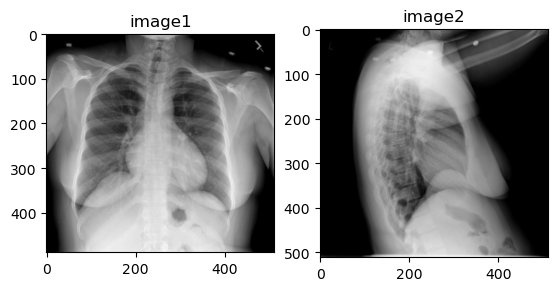

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2940_IM-1341-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2940_IM-1341-2001.png
blue:  (0, 0, 0, 0)
rouge:  0.0
rouge_l:  0.0
meteor:  0.0
ACTUAL REPORT:  <sos> normal chest  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality lucent lesion with thin sclerotic margin the right humeral head considering the associated degenerative changes large geode most 
****************************************************************************************************


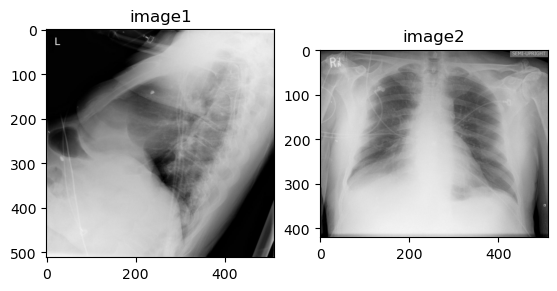

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR455_IM-2086-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR455_IM-2086-4004.png
blue:  (0, 0, 0, 0)
rouge:  0.0
rouge_l:  0.0
meteor:  0.0
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  left picc the mid svc negative for pneumothorax unchanged bibasilar airspace opacities compatible with pulmonary effusions and atelectasis increased interstitial prominence may 
****************************************************************************************************


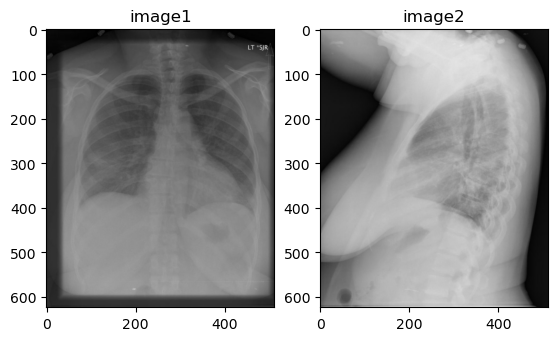

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR672_IM-2246-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR672_IM-2246-2001.png
blue:  (0, 0, 0, 0)
rouge:  0.0
rouge_l:  0.0
meteor:  0.0
ACTUAL REPORT:  <sos> vascular congestion and diffuse interstitial edema stable cardiomegaly low lung volumes  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality nodular opacity within the right hilum there large lymph node partially calcified granuloma followup radiograph assess stability may 
****************************************************************************************************


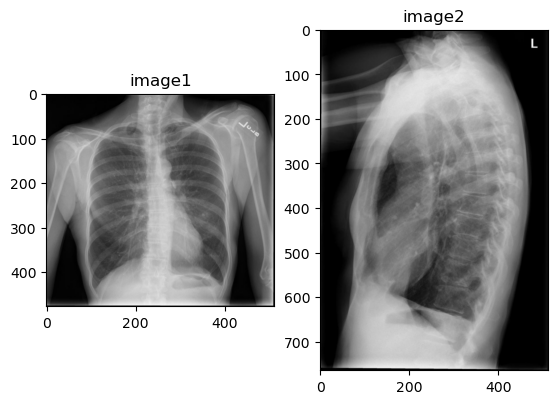

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR615_IM-2200-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR615_IM-2200-1002.png
blue:  (0, 0, 0, 0)
rouge:  0.0
rouge_l:  0.0
meteor:  0.0
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality no suspicious masses nodules  <eos>
GENERATED REPORT:  right lower lobe cavity consistent with prior tuberculous infection there increased right upper lobe cavity compared the prior study this could represent 
****************************************************************************************************


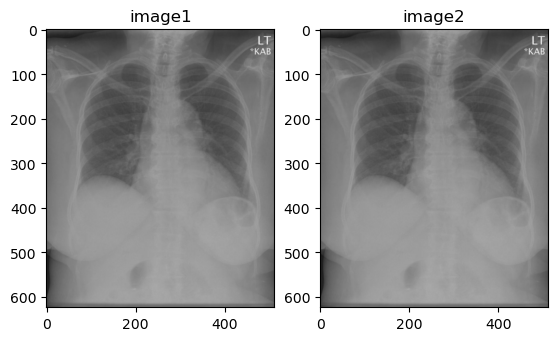

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1082_IM-0058-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1082_IM-0058-1001.png
blue:  (0, 0, 0, 0)
rouge:  0.0
rouge_l:  0.0
meteor:  0.0
ACTUAL REPORT:  <sos> stable cardiomegaly with clear lungs  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality nodular opacity within the right hilum there large lymph node partially calcified granuloma followup radiograph assess stability may 
****************************************************************************************************


In [62]:
for i in range(5):
    i1 = cv2.imread(meteor_min_five[i]["img1"])
    i2 = cv2.imread(meteor_min_five[i]["img2"])
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("image1")
    plt.imshow(i1)
    plt.subplot(132)
    plt.title("image2")
    plt.imshow(i2)
    plt.show()
    print("img1: ", meteor_min_five[i]["img1"]) 
    print("img2: ", meteor_min_five[i]["img2"]) 
    print("blue: ", meteor_min_five[i]["img_blue"]) 
    
    print("rouge: ", meteor_min_five[i]["rouge"]) 
    print("rouge_l: ", meteor_min_five[i]["rouge_l"]) 
    print("meteor: ", meteor_min_five[i]["meteor"]) 

    print("ACTUAL REPORT: ", meteor_min_five[i]["actual"])
    print("GENERATED REPORT: ", meteor_min_five[i]["generated"])


    print("*"*100)

1/1 [==============================] - 0s 31ms/step


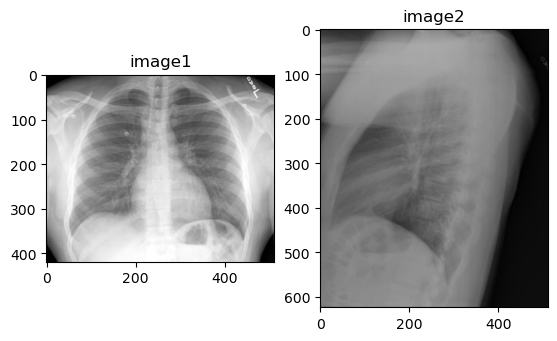

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR331_IM-1584-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR331_IM-1584-2001.png
blue:  (0.6549846024623855, 0.5178107940302672, 0.42108608162659106, 0.49473859088183875)
rouge:  0.7272727223140496
rouge_l:  0.7272727272727272
meteor:  0.635593220338983
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormalities  <eos>
GENERATED REPORT:  no acute cardiopulmonary process <eos> 
****************************************************************************************************


In [63]:
i=3
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 30ms/step


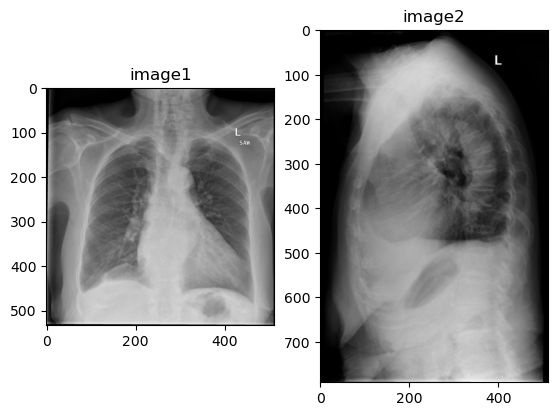

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR666_IM-2241-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR666_IM-2241-1002.png
blue:  (0.1875, 0.4330127018922193, 0.5755597559673707, 0.6580370064762462)
rouge:  0.23999999507200007
rouge_l:  0.2222222222222222
meteor:  0.13043478260869565
ACTUAL REPORT:  <sos> borderline cardiomegaly and mild chronic changes no acute infiltrate  <eos>
GENERATED REPORT:  cardiomegaly with central pulmonary vascular prominence and coarsened interstitial markings concerning for interstitial pulmonary edema <eos> 
****************************************************************************************************


In [64]:
i=536
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 29ms/step


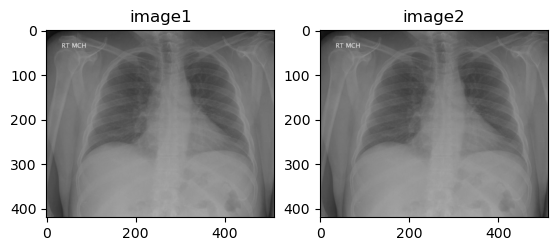

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1120_IM-0080-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1120_IM-0080-1001.png
blue:  (0.16666666666666669, 0.408248290463863, 0.5536178537956703, 0.6389431042462724)
rouge:  0.16666666166666683
rouge_l:  0.25
meteor:  0.125
ACTUAL REPORT:  <sos> limited low lung volume exam otherwise no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  heart size normal and lungs are clear no pneumothorax effusion pneumonia <eos> 
****************************************************************************************************


In [65]:
i=541
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 27ms/step


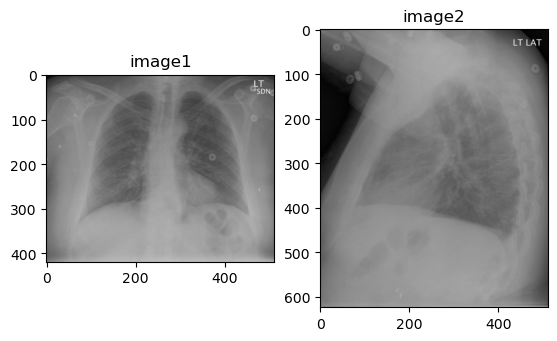

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3526_IM-1723-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3526_IM-1723-2001.png
blue:  (0.3, 0.18257418583505533, 0.325499245291693, 0.427287006396234)
rouge:  0.2999999950000001
rouge_l:  0.3
meteor:  0.25555555555555554
ACTUAL REPORT:  <sos> low lung volumes without evidence acute cardiopulmonary process  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality chronic changes consistent with emphysema <eos> 
****************************************************************************************************


In [66]:
i=562
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 30ms/step


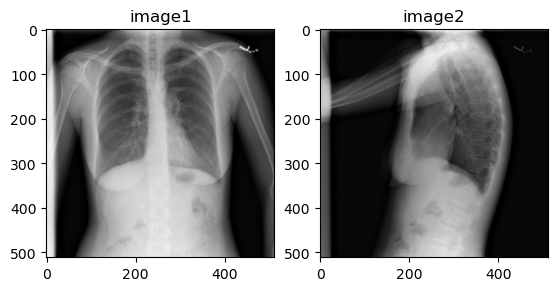

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3658_IM-1819-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3658_IM-1819-2001.png
blue:  (0.035643797633167336, 0.12851554001864682, 0.1987586395033763, 0.24402902432875526)
rouge:  0.05882352484429102
rouge_l:  0.05555555555555555
meteor:  0.022727272727272724
ACTUAL REPORT:  <sos> buckling deformity the anterior cortex the body fracture possible high energy was localized this region correlate with focal tenderness chest warranted  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality no evidence active changes from chronic tuberculosis infection <eos> 
****************************************************************************************************


In [67]:
i=451
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 29ms/step


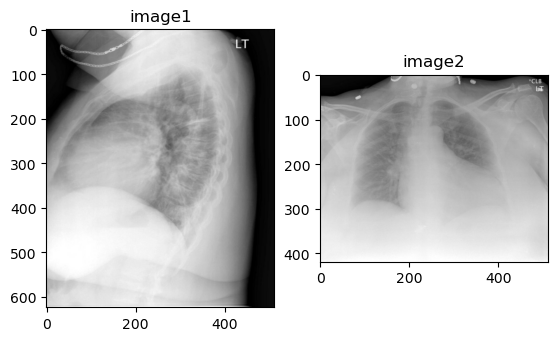

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2919_IM-1321-2001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2919_IM-1321-3001.png
blue:  (0.3333333333333333, 0.15430334996209186, 0.29129144784395883, 0.392814650900513)
rouge:  0.39999999520000007
rouge_l:  0.4
meteor:  0.3542857142857143
ACTUAL REPORT:  <sos> cardiomegaly with central pulmonary vascular congestion no edema  <eos>
GENERATED REPORT:  cardiomegaly with diffuse interstitial opacities findings may secondary pulmonary edema atypical infection another consideration <eos> 
****************************************************************************************************


In [68]:
i=456
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 30ms/step


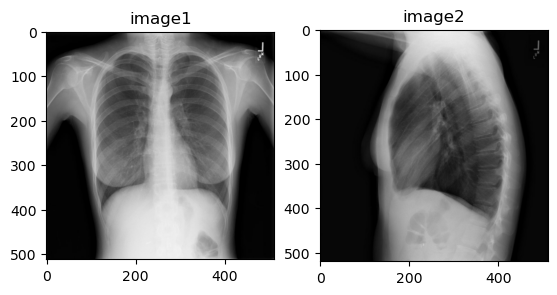

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR333_IM-1594-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR333_IM-1594-2001.png
blue:  (0.6666666666666666, 0.36514837167011077, 0.5143157015215767, 0.6042750794713536)
rouge:  0.6666666616666668
rouge_l:  0.6666666666666666
meteor:  0.5260416666666666
ACTUAL REPORT:  <sos> no acute pulmonary abnormality  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality identified <eos> 
****************************************************************************************************


In [69]:
i=1
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 23ms/step


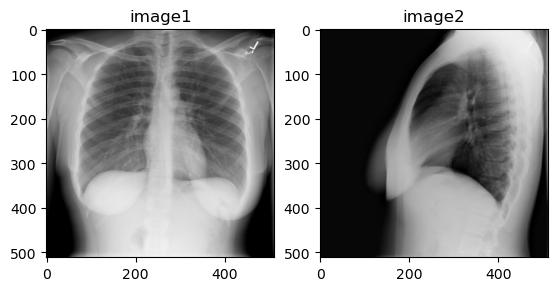

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR893_IM-2403-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR893_IM-2403-2001.png
blue:  (0.08489525565494824, 0.17672356721289068, 0.22675361834325677, 0.2549764050811409)
rouge:  0.11111110666666683
rouge_l:  0.15384615384615388
meteor:  0.060728744939271266
ACTUAL REPORT:  <sos> the heart size and cardiomediastinal silhouette are within normal limits pulmonary vasculature appears normal there no focal air space consolidation no pleural effusion pneumothorax  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality no evidence active changes from chronic tuberculosis infection <eos> 
****************************************************************************************************


In [70]:
i=136
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 26ms/step


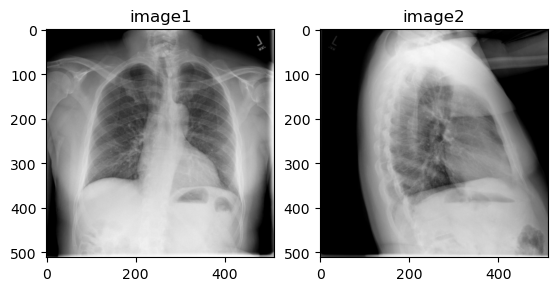

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3304_IM-1581-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3304_IM-1581-2001.png
blue:  (0.6549846024623855, 0.5178107940302672, 0.42108608162659106, 0.49473859088183875)
rouge:  0.7272727223140496
rouge_l:  0.7272727272727272
meteor:  0.635593220338983
ACTUAL REPORT:  <sos> no acute cardiopulmonary disease  <eos>
GENERATED REPORT:  no acute cardiopulmonary process <eos> 
****************************************************************************************************


In [71]:
i=12
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 24ms/step


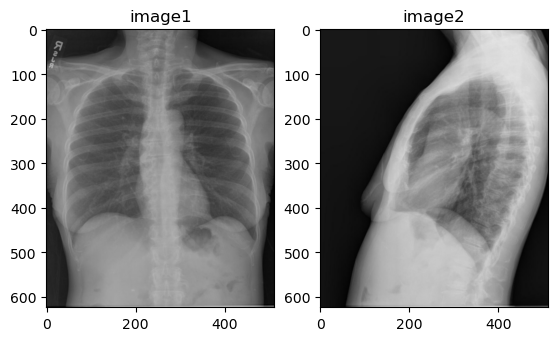

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3319_IM-1588-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3319_IM-1588-2001.png
blue:  (0.846481724890614, 0.846481724890614, 0.846481724890614, 0.846481724890614)
rouge:  0.9230769181065088
rouge_l:  0.923076923076923
meteor:  0.8675523349436391
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality identified  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality identified <eos> 
****************************************************************************************************


In [72]:
i=145
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 25ms/step


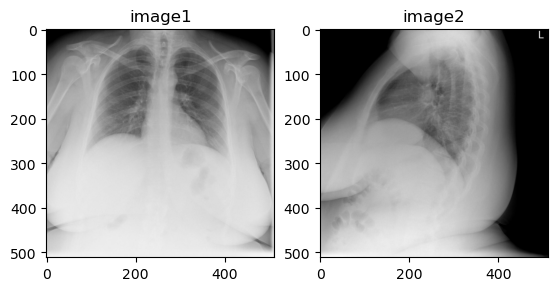

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR114_IM-0096-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR114_IM-0096-2001.png
blue:  (0.6549846024623855, 0.5178107940302672, 0.42108608162659106, 0.49473859088183875)
rouge:  0.7272727223140496
rouge_l:  0.7272727272727272
meteor:  0.635593220338983
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormalities  <eos>
GENERATED REPORT:  no acute cardiopulmonary process <eos> 
****************************************************************************************************


In [73]:
i=179
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 22ms/step


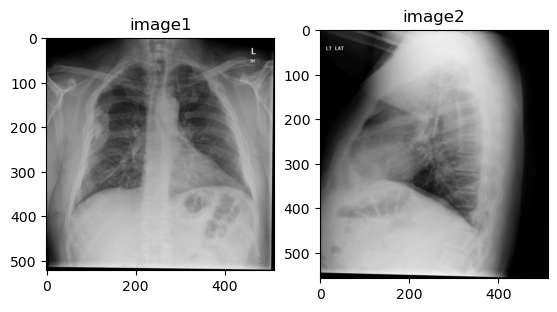

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3408_IM-1648-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3408_IM-1648-1002.png
blue:  (0.3333333333333333, 0.24618298195866542, 0.18545147779376364, 0.2790159393585827)
rouge:  0.44444444000000005
rouge_l:  0.4444444444444444
meteor:  0.5681818181818182
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  no acute cardiopulmonary process age indeterminate wedging several midthoracic vertebral bodies <eos> 
****************************************************************************************************


In [74]:
i=180
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 24ms/step


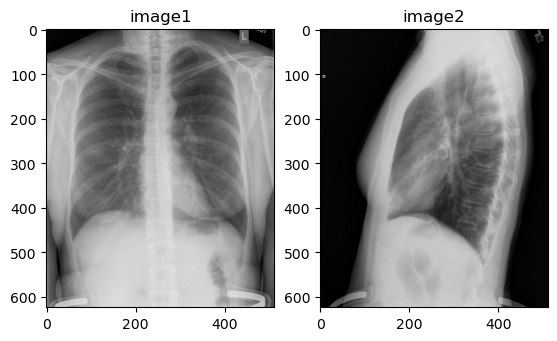

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3499_IM-1703-2002.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3499_IM-1703-3003.png
blue:  (0.2244790300552208, 0.18098077993932468, 0.15353536848256175, 0.11934387032837983)
rouge:  0.3124999953125
rouge_l:  0.30303030303030304
meteor:  0.23108808290155444
ACTUAL REPORT:  <sos> comparison well expanded and clear lungs mediastinal contour within normal limits no acute cardiopulmonary abnormality identified stable chest  <eos>
GENERATED REPORT:  no acute cardiopulmonary abnormality no evidence active changes from chronic tuberculosis infection <eos> 
****************************************************************************************************


In [75]:
i=181
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 24ms/step


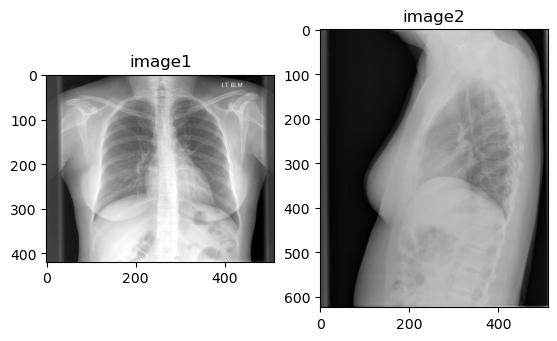

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3763_IM-1883-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3763_IM-1883-2001.png
blue:  (0.4, 0.6324555320336759, 0.7390601692542803, 0.7952707287670506)
rouge:  0.3999999950000001
rouge_l:  0.4000000000000001
meteor:  0.20000000000000004
ACTUAL REPORT:  <sos> no active disease  <eos>
GENERATED REPORT:  no acute cardiopulmonary process <eos> 
****************************************************************************************************


In [76]:
i=182
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 24ms/step


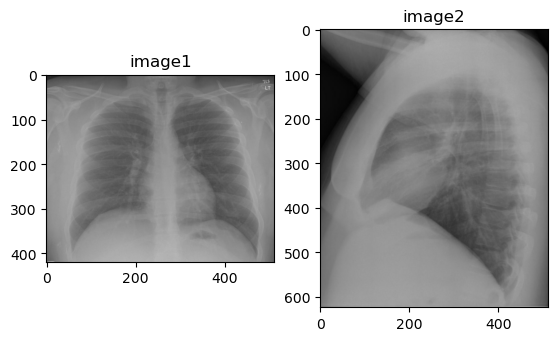

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1330_IM-0213-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1330_IM-0213-2001.png
blue:  (0.40219202762138356, 0.259613837492502, 0.3584200719902964, 0.4171622699855093)
rouge:  0.499999995138889
rouge_l:  0.5
meteor:  0.3758169934640523
ACTUAL REPORT:  <sos> negative for acute cardiopulmonary findings  <eos>
GENERATED REPORT:  no acute cardiopulmonary process <eos> 
****************************************************************************************************


In [77]:
i=188
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 22ms/step


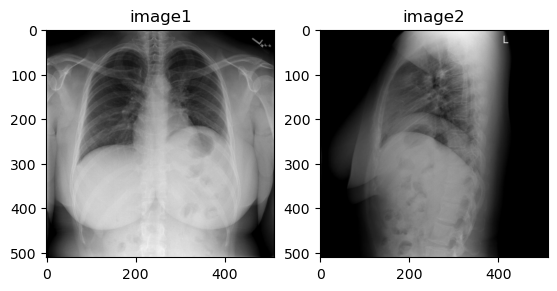

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2117_IM-0745-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2117_IM-0745-2001.png
blue:  (0.043932856352621126, 0.10761308100691222, 0.1459320818703095, 0.16842357369809585)
rouge:  0.10256409830374771
rouge_l:  0.1
meteor:  0.03787878787878788
ACTUAL REPORT:  <sos> stable appearance chest without active process evident and without evidence progression disease patient with history hodgkin lymphoma one would like discuss this case further please thanks  <eos>
GENERATED REPORT:  no acute cardiopulmonary process age indeterminate wedging several midthoracic vertebral bodies <eos> 
****************************************************************************************************


In [78]:
i=481
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

In [79]:
distinct_count = df['Result'].nunique()

# Print the distinct count
print("Distinct Result count :", distinct_count)

Distinct Result count : 70


In [80]:
distinct_count = df['Actual'].nunique()

# Print the distinct count
print("Distinct Result count :", distinct_count)

Distinct Result count : 391


In [81]:
import os
os.makedirs('/kaggle/output/', exist_ok=True)

In [82]:
import shutil

In [83]:
output_file_path = "/kaggle/working/encoder_decoder_epoch_8020_22GRU.h5"
destination_dir = "/kaggle/output/"
shutil.copy(output_file_path, destination_dir)

'/kaggle/output/encoder_decoder_epoch_8020_22GRU.h5'

In [84]:
output_file_path = "/kaggle/working/ED_8020_22GRU_results.csv"
destination_dir = "/kaggle/output/"
shutil.copy(output_file_path, destination_dir)

'/kaggle/output/ED_8020_22GRU_results.csv'